# Sistema de reconhecimento e identificação de faces

O trabalho busca implementar um algoritmo para cadastro de bancos de imagens que possuam fotos do rosto de pessoas (pode-se associar aos funcionários de uma empresa ou aos alunos de uma escola), e através de redes neurais convolucionais receber uma imagem de uma pessoa, reconhecer a face na imagem e verificar se a face na imagem percetence a alguma pessoa cadastrada.

In [6]:
import os       #lib para manipulação de arquivos
import cv2      #lib para manipulação de imagens
import torch

import matplotlib.pyplot as plt     #lib para plotar as imagens na tela
from PIL import Image               #lib para armazenamento e manipulação de imagens
from torchvision import transforms  #lib para reconhecimento de faces nas imagens
import numpy as np
import requests

users_path = os.path.join(os.getcwd(), 'fotos')

### Função que cria imagens nos arquivos associados (Sorria e acene)

In [3]:
def pega_usuario(root_path: str, username: str):
    save_path = os.path.join(root_path, username)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    
    vid = cv2.VideoCapture(0)   # Turn on the cam

    imgs = []
    while(True): 

        # Captura cada frame
        ret, frame = vid.read() 

        # Exibe cada frame
        cv2.imshow('frame', frame) 

        # O botão 'q' para desligar 
        # O botão 'w' para tirar uma foto
        # Captura até 50

        if cv2.waitKey(1) & 0xFF == ord('w'):
            imgs.append(frame)
            cv2.imwrite(os.path.join(save_path, '{0}.jpg'.format(len(imgs))), frame)
            print('{0} frames capturados'.format(len(imgs)))
            
            if len(imgs) == 50: break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    
    vid.release() 
    # Destroi as janelas de video
    cv2.destroyAllWindows() 

#pega_usuario(users_path, 'Luiz_Gusttavo')   # Teste você mesmo...

1 frames capturados


### Faz o download de um modelo já pré-treinado para reconhecimento de faces dentro de fotos
Esse modelo de Rede Neural Convolucional foi criado e treinado pelo Samuel Albani da universidade de Oxford e está disponível na internet. O modelo possui um conhecimento em reconhecer faces, contudo, o modelo ainda não conhece as faces dos usuários que queremos colocar no sistema de identificação

### Pacote para detecção da face na imagem
O pacote a seguir é o MTCNN e faz a detecção das faces dentro de imagens, nesse caso estou assumindo que em cada imagem haverá apenas uma face e portanto pegarei apenas a primeira face que o MTCNN detectar. Perceba que esse pacote apenas localiza as faces dentro da imagem e diz suas posições, ele não faz reconhecimentos.

O que acontece é que algoritmo vai pegar as imagens em matrizes de pixels e através de uma rede neural convolucional vai buscar características identificáveis de cada face e utilizando isso irá comparar a face identificada na imagem com as características extraídas das faces do arquivo pré-organizado na pasta **fotos**

In [3]:
# Instancia e treina o modelo de CNN resnet
# Instancia o detector de faces na imagem

import mtcnn
from resnet50_ft_dag import resnet50_ft_dag

detector = mtcnn.MTCNN()
model = resnet50_ft_dag('resnet50_ft_dag.pth')
print(model)

Resnet50_ft_dag(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu_7x7_s2): ReLU()
  (pool1_3x3_s2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2_1_1x1_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_1x1_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_1x1_reduce_relu): ReLU()
  (conv2_1_3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_1_3x3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_3x3_relu): ReLU()
  (conv2_1_1x1_increase): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_1x1_increase_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

1/1 [==============================] - 0s 28ms/step


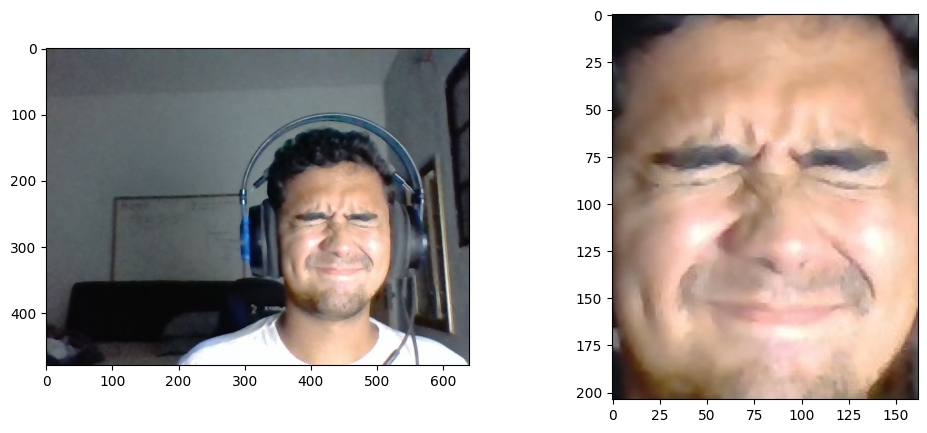

In [33]:
# Função para extração de características a partir de uma imagem
def extract_features(pixels):
    pixels = np.array(pixels, dtype=np.uint8)
    
    # Recortando a face
    faces = detector.detect_faces(pixels)   # Retorna a lista de faces que encontrar na imagem
    x, y, width, height = faces[0]['box']   # Pega apenas a primeira face
    face = pixels[y:y+height, x:x+width]    # Recorta apenas a face na imagem
    
    # Plot da imagem e da face recortada
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(pixels)   # Imagem passada
    axs[1].imshow(face)     # Face achada pelo detector
    
    # Extrai caracteristicas de alto nível
    face = Image.fromarray(face, 'RGB')
    face = transforms.Resize( (224, 224) )(face)
    face = transforms.ToTensor()(face).unsqueeze(0)
    
    class_, feature = model(face)   # Extração real de pesos como feature
    
    return feature.detach().cpu().data.squeeze()
    
imagem = Image.open(os.path.join(users_path, 'Luiz_Gusttavo', '1.jpg'))
feature = extract_features(imagem)
# print(feature.shape)

### Usando a função de extração de características

Agora é possível utilizar a função criada para pegar nossos usuários do banco de dados e extrair características de todos eles a fim de usar essas características como referências para futuras comparações com novas imagens.

In [30]:
# Função para guardar features de referência para um usuário
# recebe o nome da pessoa com iniciais maiúsculas e _ separando

from torch import nn

metrica = nn.L1Loss()   # Metrica de distancia euclidiana

def aprende_usuario(usuario: str):
    user_path = os.path.join(users_path, usuario)
    all_features = []

    # Percorrer imagens extraindo características alto nível
    for img in os.listdir(user_path):
        if(img.split(sep='.')[1] == 'jpg'):
            pixels = Image.open(os.path.join(user_path, img))
            feature = extract_features(pixels) 

            all_features.append(feature)

    # Pega a média e o desvio padrão para comparar distancias euclidianas entre
    # as features de imagens diferentes
    all_losses = []
    for k in range(len(all_features)):
        for j, feat in enumerate(all_features):
            if k == j: continue
            all_losses.append(metrica(all_features[k], feat))

    all_losses = np.asarray(all_losses)
    print(np.mean(all_losses), np.std(all_losses)) # Imprime media e desvio padrao das distancias

    all_feats = np.asarray([feat.numpy() for feat in all_features])
    np.savez_compressed(os.path.join(user_path, 'referencia'), all_feats=all_feats, mean=np.mean(all_losses), std=np.std(all_losses))


aprende_usuario('Serena_Williams')



1/1 [==============================] - 0s 26ms/step
0.24691342 0.016441485


### Testando com imagens desconhecidas

Agora iremos usar a camera do computador novamente para capturar imagens, dessa vez apenasa uma nova imagem. Pode-se fazer uma analogia com a camera de segurança de um prédio comercial ou uma webCam de um computador na portaria que vai capturar a imagem de quem tenta acessar o local e verificar se aquela pessoa está cadastrada no banco. 

Depois de capturar uma imagem nova, extrairemos os componentes importantes daquela imagem como uma feature e faremos a comparação com todas as features anteriormente armazenadas no banco. Após a comparação o modelo será capz de julgar se a pessoa na nova imagem foi **reconhecida ou não** e se for reconhecida ele será capaz de dizer **o nome da pessoa na nova imagem**.

In [25]:
def get_new_img():

    vid = cv2.VideoCapture(0) 

    ret = []
    while(True): 
        ret, frame = vid.read() 
        cv2.imshow('frame', frame) 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            ret = frame
            print('1 frame capturado')
            break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    vid.release() 
    cv2.destroyAllWindows() 
    
    return ret

1 frame capturado
1/1 [==============================] - 0s 28ms/step
Usuário não identificado


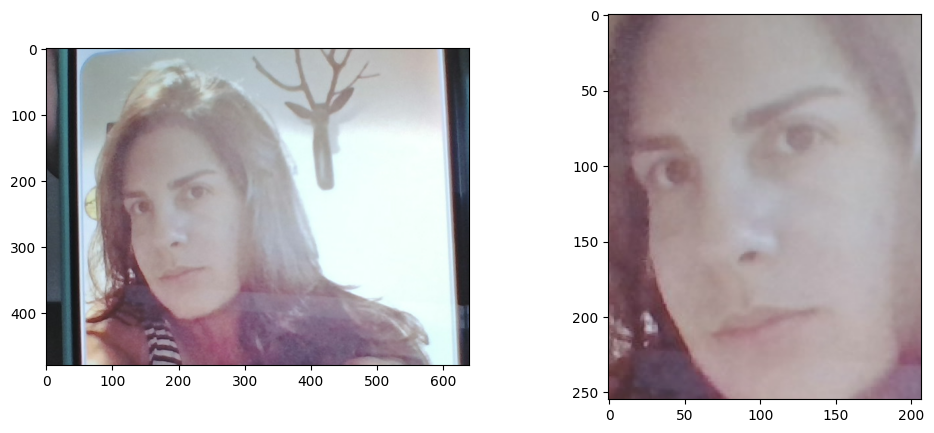

In [45]:
# Pega nova imagem
pixels = cv2.cvtColor(get_new_img(), cv2.COLOR_BGR2RGB)
feature = extract_features( pixels )

# Compara feature da nova imagem com as referências
# previamente armazenadas.
reconhecido = False
for user in os.listdir(users_path):
    
    referencia = np.load(os.path.join(users_path, user, 'referencia.npz'))
    all_features = referencia['all_feats']
    mean = referencia['mean']
    std  = referencia['std']
    
    all_dist = []
    for feat in all_features:
        all_dist.append(metrica(feature, torch.from_numpy(feat) ))
        
    # Critério de identificação. Para cada usuário:
    #    calcule a média da distância da nova imagem com todas as imagens de referência
    #    compare com a média da diferença das imagens de referência entre si
    #    se a diferença estiver dentro de 1 desvio padrão, é possível que seja a pessoa!
    
    if abs( np.mean(all_dist) - mean ) < std:
        print('Identidade:', user.capitalize())
        reconhecido = True
        
if not reconhecido:
    print('Usuário não identificado')